In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [6]:
staticfile = "/home/glemieux/Data/luh2/staticData_quarterdeg.nc"
surfdatfile = '/home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
clmsurffile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc'
forestfile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhforest_deg025.nc'
otherfile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc'
pasturefile = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhpasture_deg025.nc'

In [7]:
ds_static = xr.open_dataset(staticfile)
ds_surf = xr.open_dataset(surfdatfile)
ds_clmsurf = xr.open_dataset(clmsurffile)
ds_forest = xr.open_dataset(forestfile)
ds_other = xr.open_dataset(otherfile)
ds_pasture = xr.open_dataset(pasturefile)
ds_clmlist = [ds_clmsurf,ds_forest,ds_pasture,ds_other]

# Questions
1. Does the mask need to be T/F or 0/1 for xesmf regridding?
2. Do the mask Lat/Lon need to be aligned (i.e. both 0 -> 360) or can xesmf convert on the fly?
3. Should the clmsurfdat use the static icwtr mask or should it use it's own PCT_NATVEG (like the target regrid file)?

# Answers

### 1. It seems like we need to mask to avoid including NaNs:

> By default, xESMF treats NaNs like regular values hence potentially resulting in missing values bleeding into the regridded field and creating insconsistencies in the resulting masked array.

xESMF examples use `1/0` values where the `NaN` are to mask

> `ds["mask"] = xr.where(~np.isnan(ds["zeta"].isel(ocean_time=0)), 1, 0)`

The `Regridder` reference states that it wants 1, 0 explicitly.  That said, does as T/F mask convert automatically?

> All variables that the cf-xarray accessor understand are accepted. Otherwise, look for lon, lat, optionally lon_b, lat_b for conservative methods, and mask. **Note that for mask, the ESMF convention is used, where masked values are identified by 0, and non-masked values by 1.** (emphasis mine)

Also of note; providing bounds is ideal for conservative regridding:
> For conservative methods, if bounds are not present, they will be computed using cf-xarray (only 1D coordinates are currently supported).

# Surface dataset PCT_NATVEG as mask

mask_surf = (ds_surf.PCT_NATVEG > 0)
mask_surf.plot()

Note that the lat/lon dimensions/coordinates are names `lsmlat/lsmlon` and need conversion before comparison or regridding

# Ice water as mask

In [9]:
icwtr = ds_static.icwtr.astype('float64')
mask_static_ratio = (1-icwtr) / (1-icwtr)
mask_static_not = (icwtr != 1)

Text(0.5, 1.0, 'Mask as not 1.0')

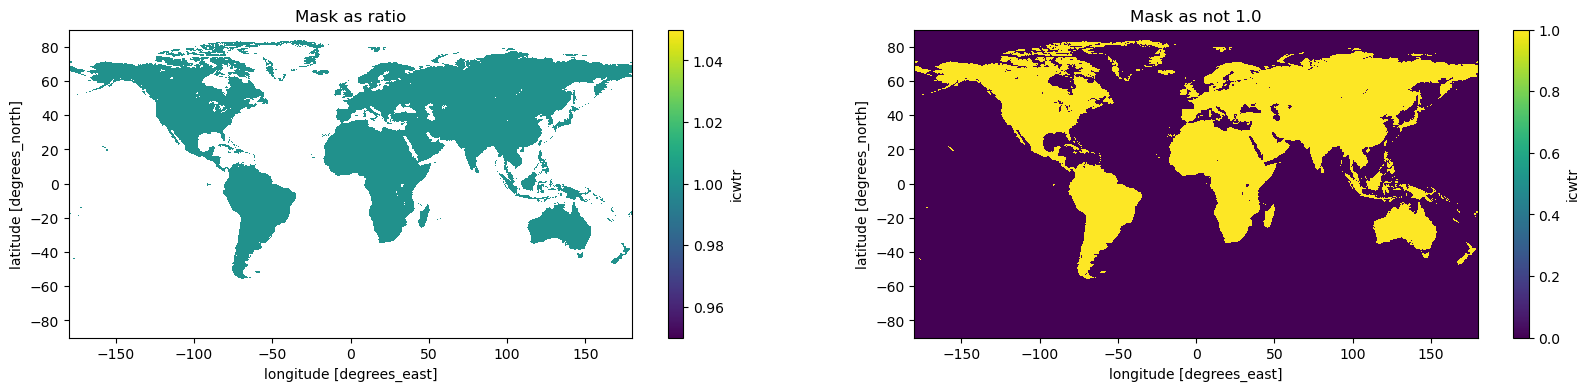

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
mask_static_ratio.plot(ax=ax1)
ax1.set_title('Mask as ratio')
mask_static_not.plot(ax=ax2)
ax2.set_title('Mask as not 1.0')

### Does the mask contain `NaN`?

In [11]:
print("icwtr != 1 nans:", mask_static_not.isnull().any().data)
print("ratio method nans:", mask_static_ratio.isnull().any().data)

icwtr != 1 nans: False
ratio method nans: True


### We can use the `where` function to make sure we get 1/0
Assuming that `T/F` doesn't automatically work for xesmf.  *Note that I think T/F* is technically ok, although I haven't found documentation referencing this.*

In [12]:
mask_static_not_01 = xr.where(mask_static_not,1,0)
mask_static_ratio_01 = xr.where(mask_static_ratio == 1.,1,0)
diff_mask_static_01 = mask_static_not_01 - mask_static_ratio_01
diff_mask_static_01.sum().data

array(0)

Since the sum of the mask is zero, the two are equivalent.  

# CLM5 surface data quarter degree `PCT_NATVEG` as mask

Note: only the CLM5 current surface data set includes `PCT_NATVEG`

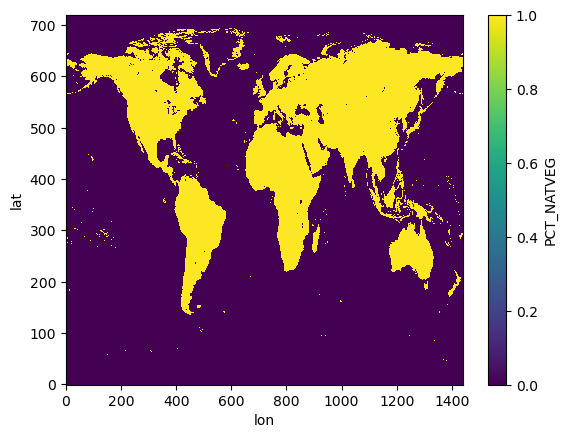

In [13]:
mask_clmsurf = xr.where(ds_clmsurf.PCT_NATVEG > 0,1,0)
mask_clmsurf.plot()

# CLM5 Forest `LANDMASK` as landmask

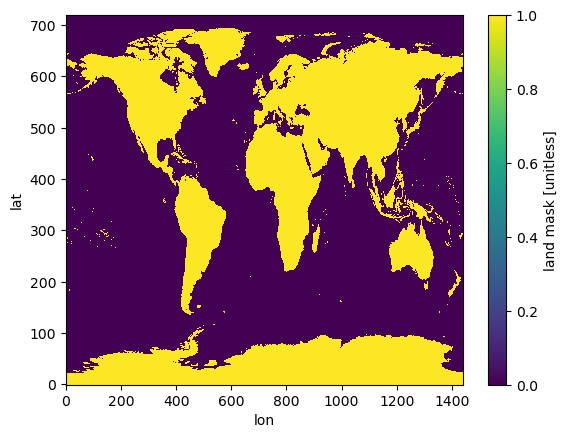

In [14]:
ds_forest.LANDMASK.plot()

In [15]:
# Note that the landmask is just the landfrac greater than zero
((ds_forest.LANDFRAC > 0) == ds_forest.LANDMASK).all()

<xarray.DataArray ()>
array(True)

# Comparing masks

## CLM5 LANDMASKS comparisons for each landuse dataset

In [16]:
diff_forest_clmsurf = ds_forest.LANDMASK - ds_clmsurf.LANDMASK
diff_clmsurf_pasture = ds_clmsurf.LANDMASK - ds_pasture.LANDMASK
diff_pasture_other = ds_pasture.LANDMASK - ds_other.LANDMASK
print("Sum of Forest - Current surface landmask differences:", diff_forest_clmsurf.sum().data)
print("Sum of Current surface - Pasture landmask differences:", diff_clmsurf_pasture.sum().data)
print("Sum of Pasture - Other surface landmask differences:", diff_pasture_other.sum().data)

Sum of Forest - Current surface landmask differences: 0.0
Sum of Current surface - Pasture landmask differences: 0.0
Sum of Pasture - Other surface landmask differences: 0.0


**Conclusion:** the CLM5 `LANDMASK` values are all the same.

## Comparing Static water data, landmask, and pct_natveg

**Remember to convert the current surface and static masks to `1/0`**.  Note that `xor` two logical arrays will only show positive differences!

In [17]:
# Diff landmask and current surf mask
# diff_landmask_pctmask = ds_forest.LANDMASK - xr.where(mask_clmsurf,1,0)
diff_landmask_pctmask = ds_forest.LANDMASK - mask_clmsurf

# Convert the current surf data for comparison first
mask_clmsurf_copy = mask_clmsurf.copy(deep=True)
mask_clmsurf_copy["lon"] =  mask_clmsurf.lon * 0.25 - 180. + 1./8.
mask_clmsurf_copy["lat"] =  mask_clmsurf.lat * 0.25 - 90. + 1./8.

# Diff current surf mask and static icwtr mask, use logical xor to compare where T/F don't match
# diff_pctmask_staticmask = xr.where(mask_clmsurf_copy,1,0) - xr.where(mask_static_not,1,0)
# diff_pctmask_staticmask = np.logical_xor(mask_clmsurf_copy, mask_static_not)
diff_pctmask_staticmask = mask_clmsurf_copy - mask_static_not_01

Text(0.5, 1.0, 'PCT_NATVEG - Static icwtr')

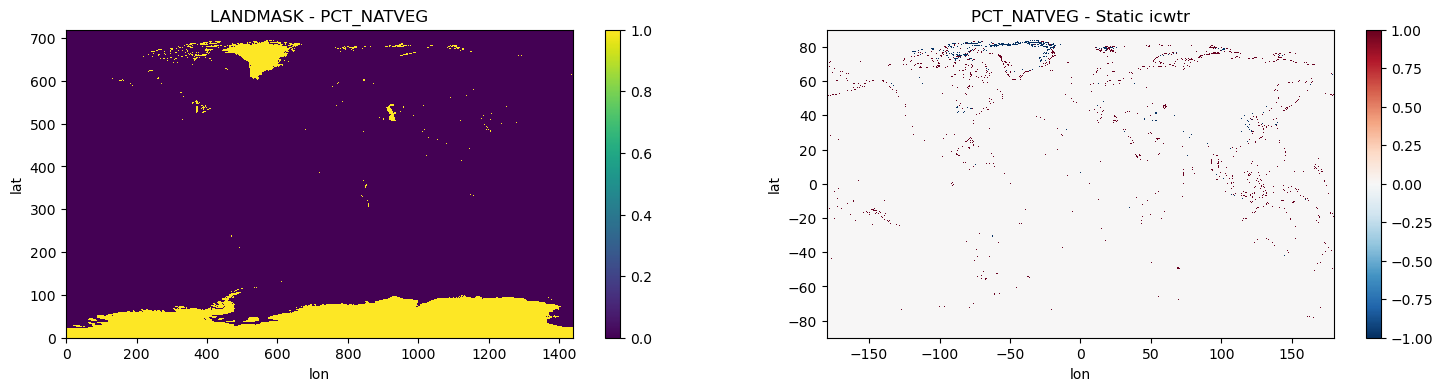

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
diff_landmask_pctmask.plot(ax=ax1)
ax1.set_title('LANDMASK - PCT_NATVEG')
diff_pctmask_staticmask.plot(ax=ax2)
ax2.set_title('PCT_NATVEG - Static icwtr')

In [19]:
print("diff_landmask_pctmask sum where not 1 is zero:", ((diff_landmask_pctmask.where(diff_landmask_pctmask != 1.0).sum()) == 0.).data)

diff_landmask_pctmask sum where not 1 is zero: True


The `LANDMASK` includes areas that we don't want to include as land, like Greenland, Antarctica and the Caspian Sea.  The `PCT_NATVEG` from the current surface data and the static icwtr mask have areas that they don't overlap.  
**Conclusion:** Use the `PCT_NATVEG` should be joined with the icwtr.

# Comparing the calculated fraction of bareground against masks

## Comparing the *non-bareground* percentage from each landuse dataset

In [20]:
nonbaresum = []
for i,ds in enumerate(ds_clmlist):
    nonbaresum.append(ds.PCT_NAT_PFT.isel(natpft=slice(1,None)).sum(dim='natpft'))

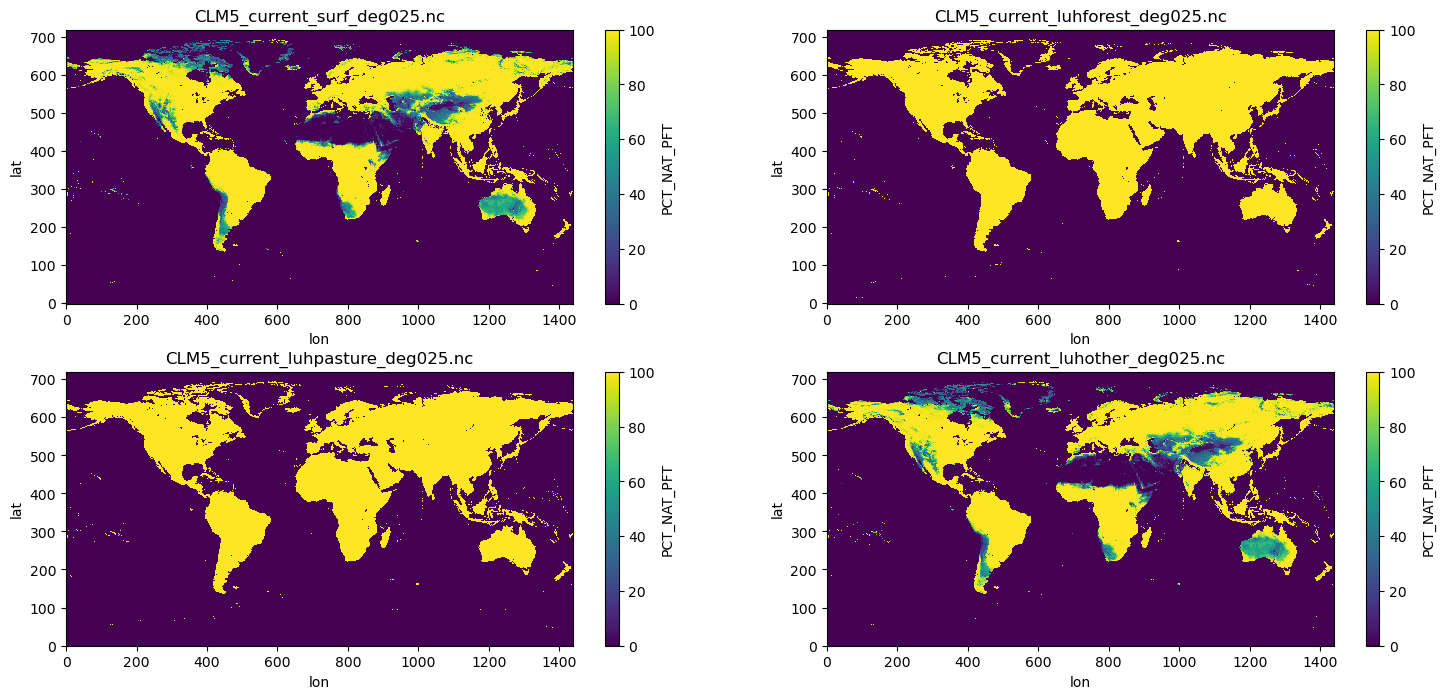

In [21]:
f, ax = plt.subplots(2, 2, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25)
for i,ai in enumerate(ax.flat):
    nonbaresum[i].plot(ax=ai)
    ai.set_title(ds_clmlist[i].title)

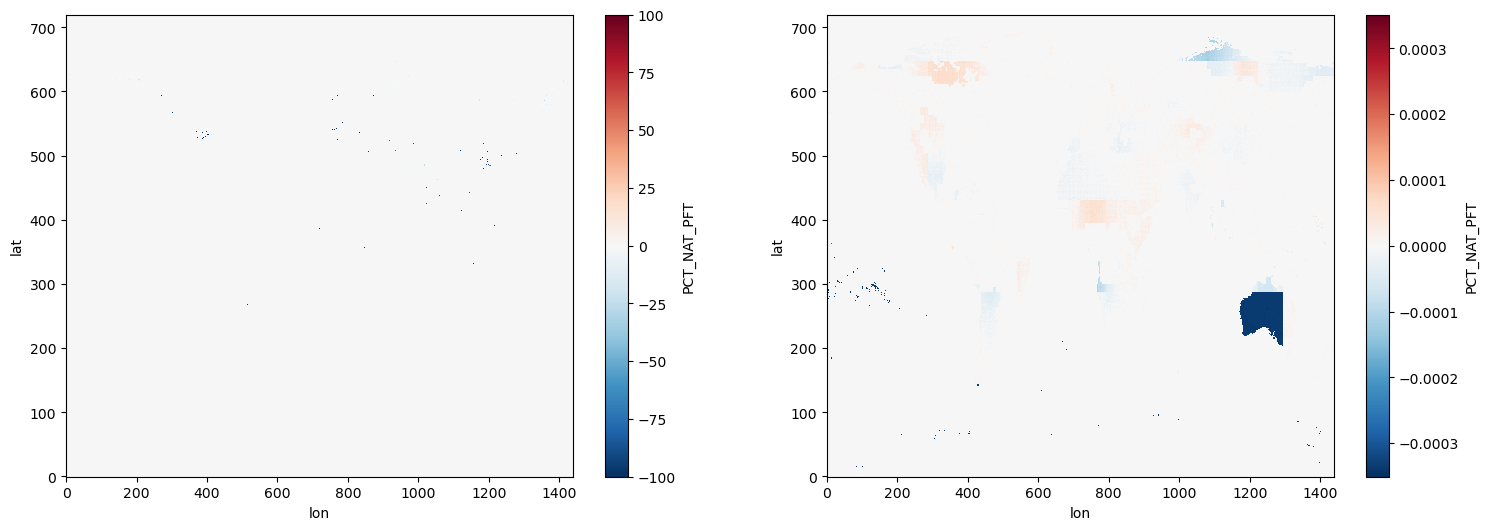

In [22]:
f,ax = plt.subplots(1,2,figsize=(18,6))
(nonbaresum[0] - nonbaresum[3]).plot(ax=ax[0])
(nonbaresum[1] - nonbaresum[2]).plot(ax=ax[1])

## Comparing the bareground percentage from each landuse dataset

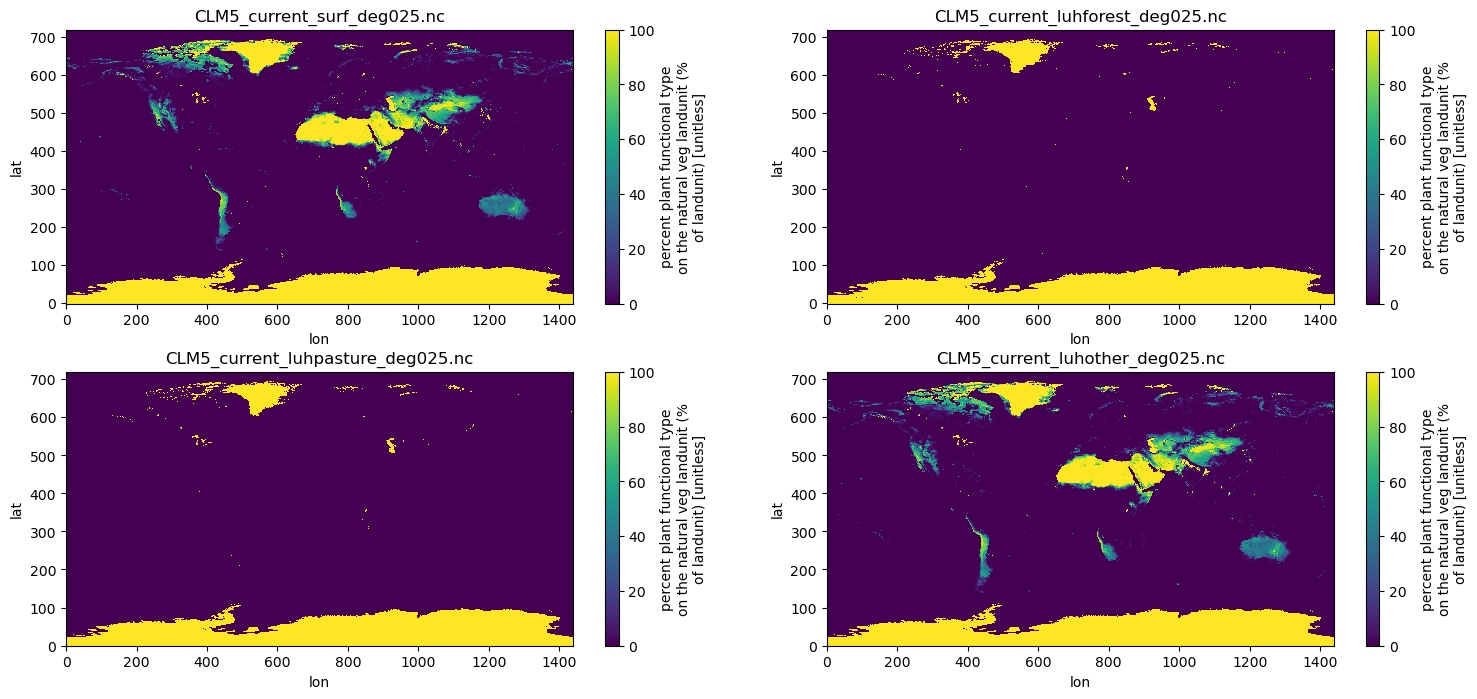

In [23]:
ds_clmlist = [ds_clmsurf, ds_forest, ds_pasture, ds_other]
f, ax = plt.subplots(2, 2, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25)
for i,ai in enumerate(ax.flat):
    ds_clmlist[i].PCT_NAT_PFT.isel(natpft=0).plot(ax=ai)
    ai.set_title(ds_clmlist[i].title)

Text(0.5, 1.0, 'forest - pasture')

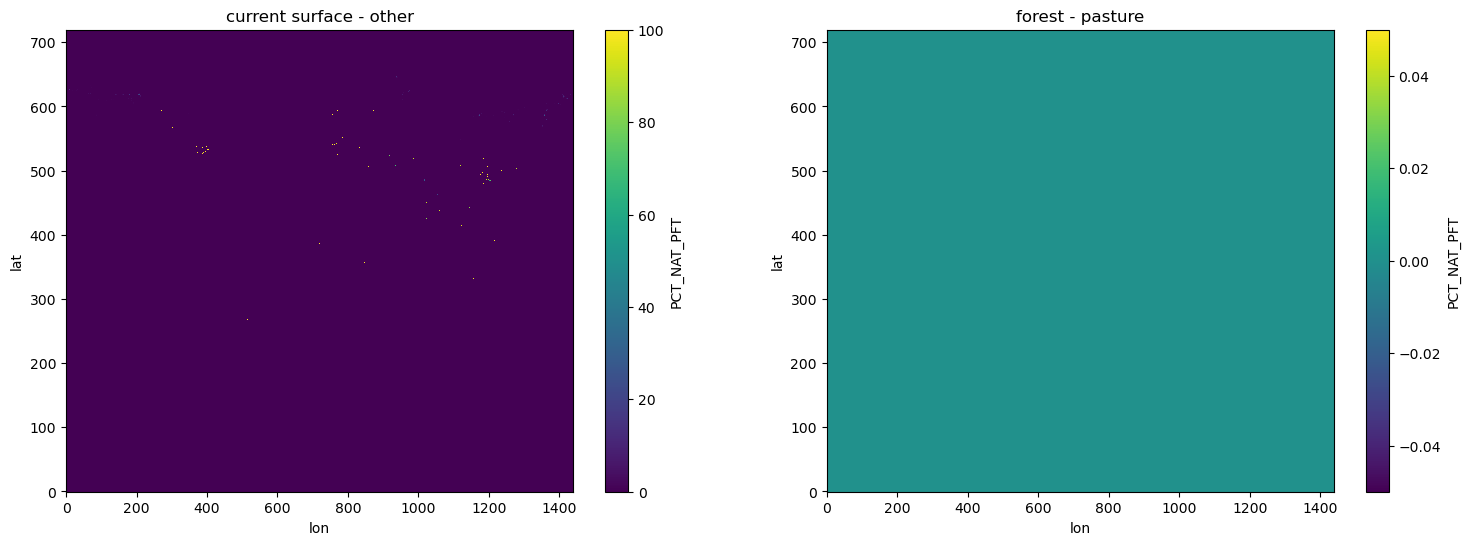

In [24]:
f,ax = plt.subplots(1,2,figsize=(18,6))
(ds_clmsurf.PCT_NAT_PFT.isel(natpft=0) - ds_other.PCT_NAT_PFT.isel(natpft=0)).plot(ax=ax[0])
(ds_forest.PCT_NAT_PFT.isel(natpft=0) - ds_pasture.PCT_NAT_PFT.isel(natpft=0)).plot(ax=ax[1])
ax[0].set_title('current surface - other')
ax[1].set_title('forest - pasture')

The current surface bareground is *inclusive* of the 'other' bareground.  The pasture and the forest baregrounds match.

*Note:* The forest bareground data points are all 100%.

In [25]:
((ds_forest.PCT_NAT_PFT.isel(natpft=0) == 100.) == (ds_forest.PCT_NAT_PFT.isel(natpft=0) > 0.)).all()

<xarray.DataArray 'PCT_NAT_PFT' ()>
array(True)
Coordinates:
    natpft   int32 0

How do the current surface and forest dataset bareground compare?

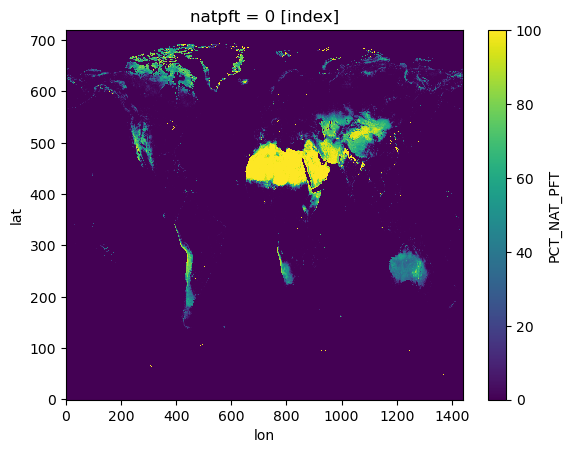

In [26]:
(ds_clmsurf.PCT_NAT_PFT.isel(natpft=0) - ds_forest.PCT_NAT_PFT.isel(natpft=0)).plot()

Since the values are all positive, the current surface bareground is *inclusive* of the forest/pasture bareground.

### Define mask where the current surface bareground is equal to 100

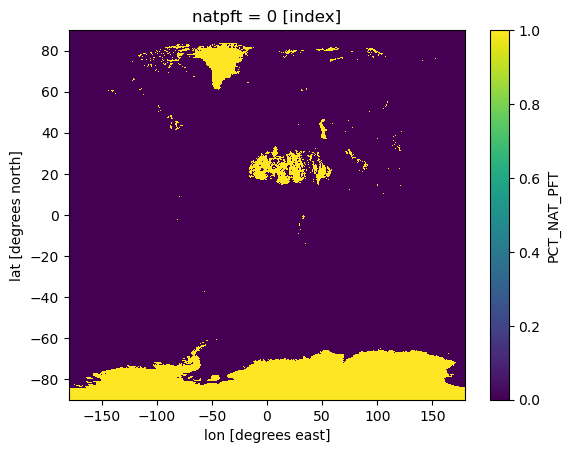

In [37]:
mask_bareground_100p = xr.where(ds_clmsurf.PCT_NAT_PFT.isel(natpft=0) == 100.,1,0)
mask_bareground_100p.plot()
# ds_clmsurf.PCT_NAT_PFT.isel(natpft=0).where(ds_clmsurf.PCT_NAT_PFT.isel(natpft=0) == 100.).plot()

Compare where the 100% surface bareground and the forest bareground do not match.

Text(0.5, 0.98, 'Comparison of 100% bareground')

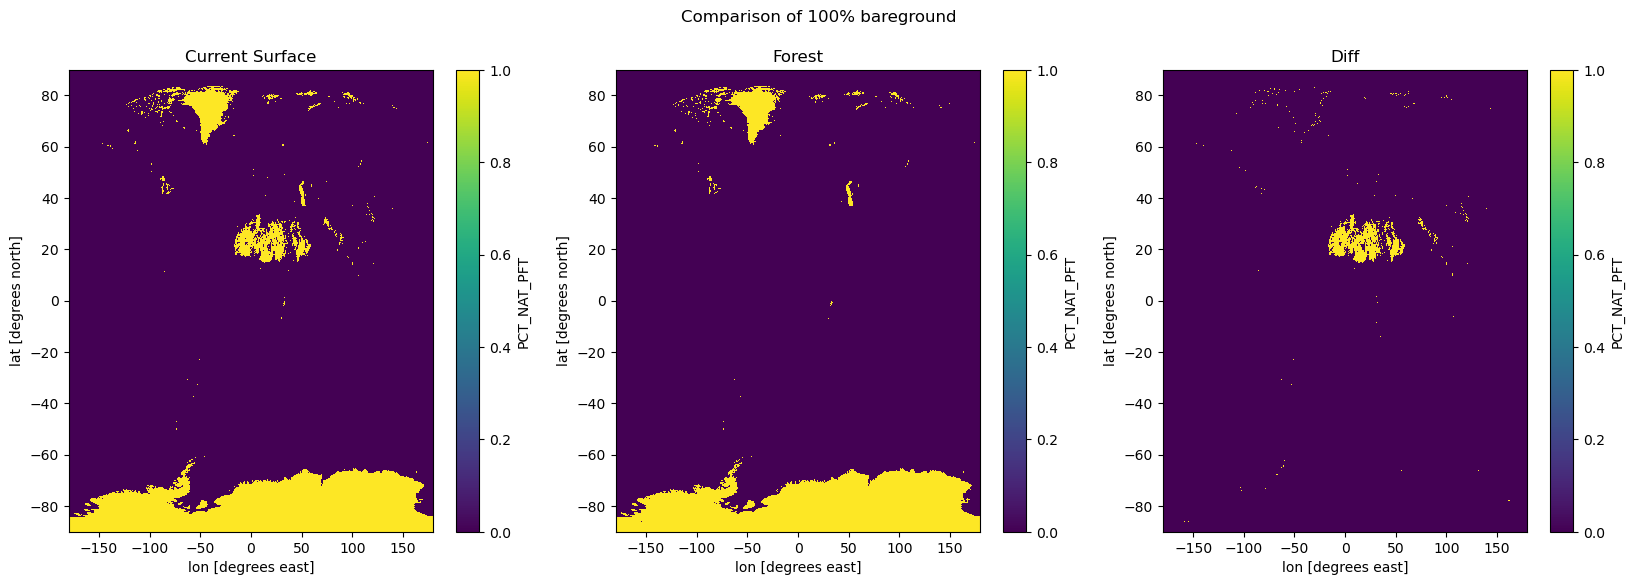

In [96]:
mask_forest_bareground = xr.where(ds_forest.PCT_NAT_PFT.isel(natpft=0) > 0.,1,0)
mask_diff_forest_clmsurfbareground = mask_bareground_100p - mask_forest_bareground
f,ax = plt.subplots(1,3,figsize=(20,6))
mask_bareground_100p.plot(ax=ax[0])
ax[0].set_title("Current Surface")
mask_forest_bareground.plot(ax=ax[1])
ax[1].set_title("Forest")
mask_diff_forest_clmsurfbareground.plot(ax=ax[2])
ax[2].set_title("Diff")
f.suptitle("Comparison of 100% bareground")

Text(0.5, 1.0, 'Difference')

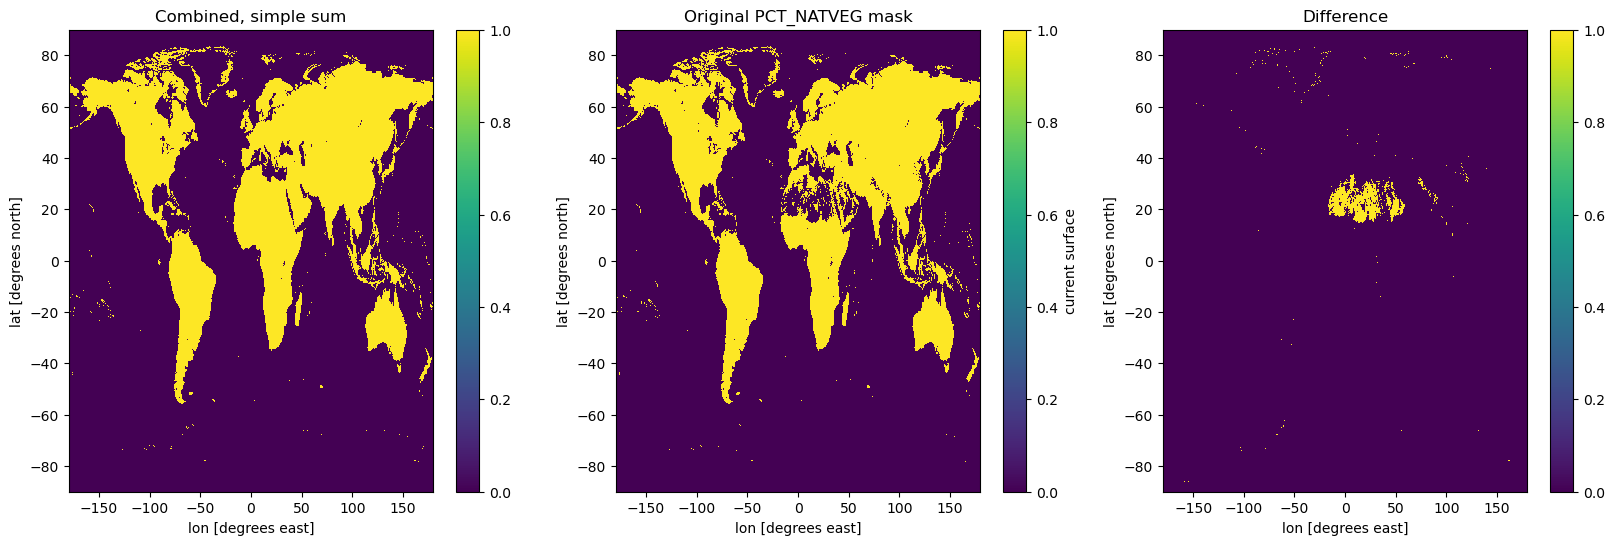

In [97]:
mask_clmsurf_diff = mask_diff_forest_clmsurfbareground + mask_clmsurf
f,ax = plt.subplots(1,3,figsize=(20,6))
mask_clmsurf_diff.plot(ax=ax[0])
ax[0].set_title("Combined, simple sum")
mask_clmsurf.plot(ax=ax[1])
ax[1].set_title("Original PCT_NATVEG mask")
(mask_clmsurf_diff - mask_clmsurf).plot(ax=ax[2])
ax[2].set_title("Difference")

In [99]:
((mask_clmsurf_diff - mask_clmsurf) == mask_diff_forest_clmsurfbareground).all().values

array(True)

## Where is the static data fstnf masking?

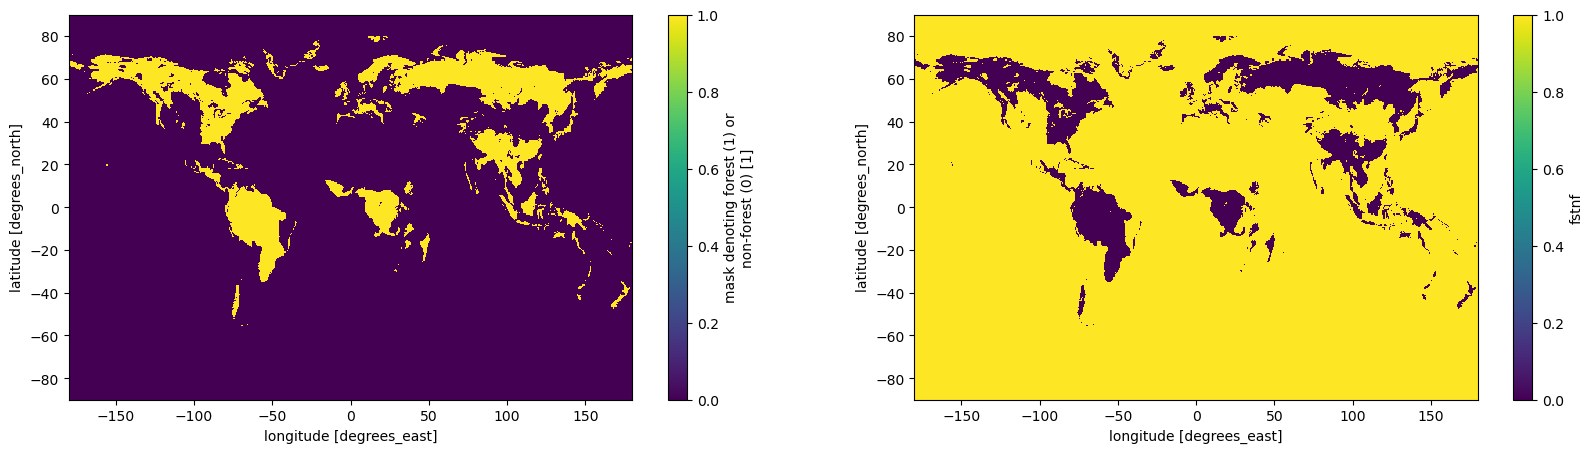

In [30]:
mask_fstnf = ds_static.fstnf
f,ax = plt.subplots(1,2,figsize=(20,5))
mask_fstnf.plot(ax=ax[0])
(1.-mask_fstnf).plot(ax=ax[1])

### What does the primary and secondary plot look like on it's own and when combined/applied to the percent data?

In [31]:
percent = []
for i,ds in enumerate(ds_clmlist):
    # First convert to lat/lon
    ds['lat'] = ds.LAT
    ds['lon'] = ds.LON
    temppercent = ds.PCT_NAT_PFT.isel(natpft=slice(1,None))
    temppercent = temppercent / temppercent.sum(dim='natpft')
    percent.append(temppercent)

CLM5_current_luhforest_deg025.nc
CLM5_current_luhother_deg025.nc


Text(0.5, 1.0, 'Primary + Secondary')

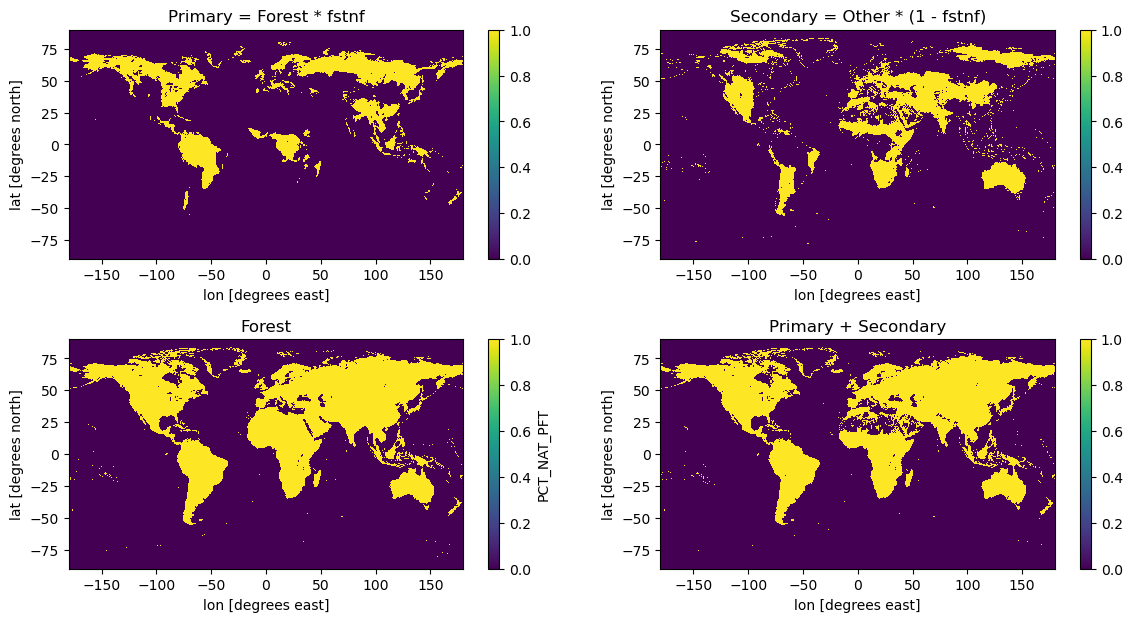

In [32]:
index_forest = 1
index_other = -1
print(ds_clmlist[index_forest].title)
percent_primary = percent[index_forest] * mask_fstnf
print(ds_clmlist[index_other].title)
percent_secondary = percent[index_other] * (1. - mask_fstnf)
f,ax = plt.subplots(2,2,figsize=(14,7))
percent_primary.sum(dim='natpft').plot(ax=ax[0,0])
percent_secondary.sum(dim='natpft').plot(ax=ax[0,1])
percent[index_forest].sum(dim='natpft').plot(ax=ax[1,0])
(percent_primary + percent_secondary).sum(dim='natpft').plot(ax=ax[1,1])
f.subplots_adjust(hspace=0.35)
ax[0,0].set_title('Primary = Forest * fstnf')
ax[0,1].set_title('Secondary = Other * (1 - fstnf)')
ax[1,0].set_title('Forest')
ax[1,1].set_title('Primary + Secondary')

### Extra: Does joining the current surface `PCT_NATVEG` to the current surface 100% bareground mask result in an existing mask?

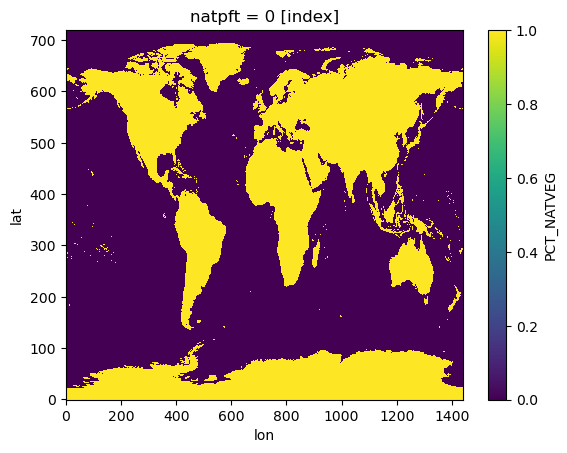

In [33]:
full_mask = np.logical_or(mask_clmsurf,mask_bareground_100p)
full_mask.plot()

### Compare this mask to the sum of all the natpfts for forest

In [36]:
mask_forest_all_natpft = ds_forest.PCT_NAT_PFT.sum(dim='natpft') > 0.
(full_mask == mask_forest_all_natpft).all().values

array(True)

**Conclusion:** The computed 'full_mask' (current surface `pct_natveg` + current surface 100% bareground) is equivalent to the sum of the `pct_nat_pft` for the forest

# Missing landuse data

## Primary + secondary

In [83]:
ds_clmlist[0].title

'CLM5_current_surf_deg025.nc'

In [103]:
mask_miss_prim_sec = xr.where(np.logical_not((percent_primary + percent_secondary).sum(dim='natpft') == 0.),1,0)
mask_miss_prim_sec.name = 'primary & secondary'
mask_miss_pasture = xr.where(np.logical_not(percent[2].sum(dim='natpft') == 0.),1,0)
mask_miss_pasture.name = 'pasture'
mask_miss_range = xr.where(np.logical_not(percent[3].sum(dim='natpft') == 0.),1,0)
mask_miss_range.name = 'range'
mask_miss_clmsurf = xr.where(np.logical_not(percent[0].sum(dim='natpft') == 0.),1,0)
mask_miss_clmsurf.name = 'current surface'

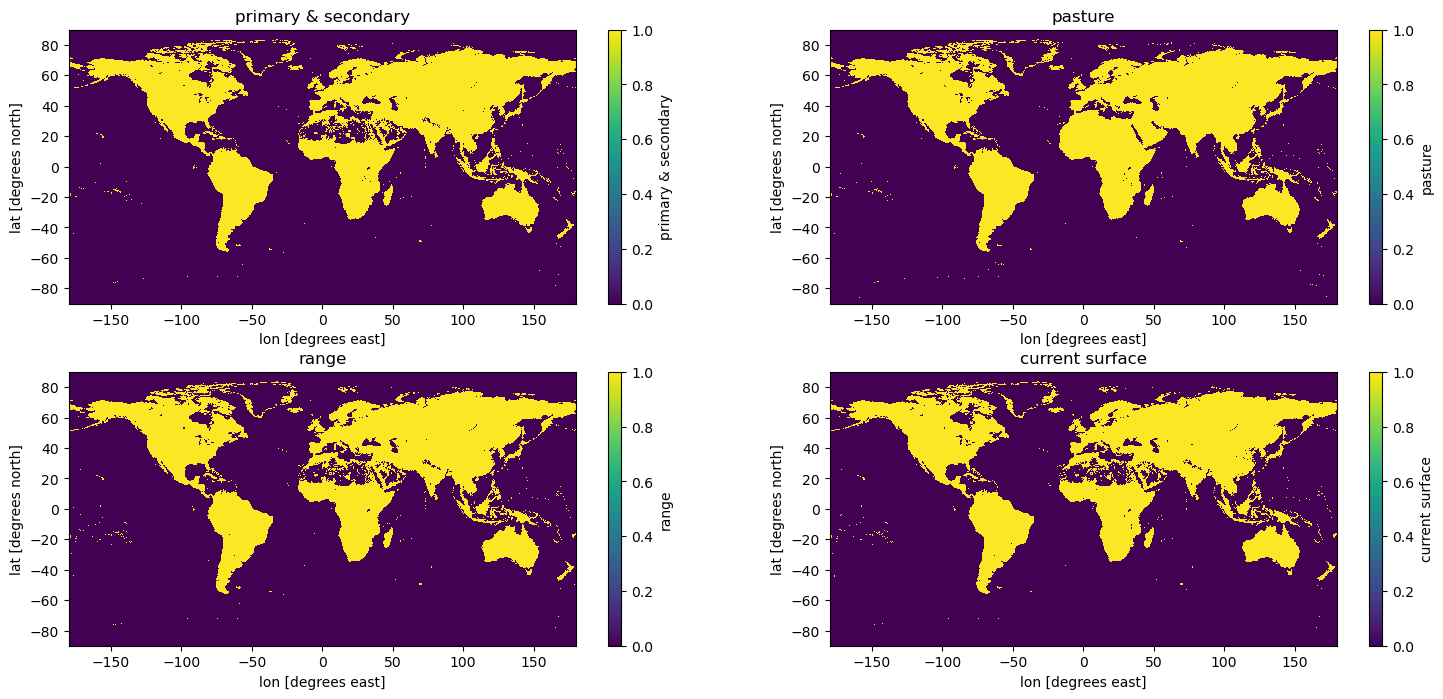

In [105]:
masklist = [mask_miss_prim_sec, mask_miss_pasture, mask_miss_range, mask_miss_clmsurf]
f, ax = plt.subplots(2, 2, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25)
for i,ai in enumerate(ax.flat):
    masklist[i].plot(ax=ai)
    ai.set_title(masklist[i].name)

# Assembling masks

Charlie uses the following combination to make landuse specific masks:

1. the ice/water mask
2. where the bare ground mask has Nan values
3. where the land is 100% bare ground
4. where there is missing data in the landuse dataset

## Sequential combination

In [67]:
# Union of natveg and icwtr
mask_natveg_icwtr = mask_clmsurf_copy | mask_static_not_01
mask_natveg_icwtr.name = 'natveg + icwtr'

# 
mask_natveg_icwtr_bareground100p = mask_natveg_icwtr & mask_bareground_100p
mask_natveg_icwtr_bareground100p.name = 'natveg + icwtr + bg=100%'

# mask_natveg_icwtr_bareground100p_nan = mask_natveg_icwtr_bareground100p | mask_bareground_nan
# mask_natveg_icwtr_bareground100p_nan.name = 'natveg + icwtr + bg=100% + lubg!=nan'

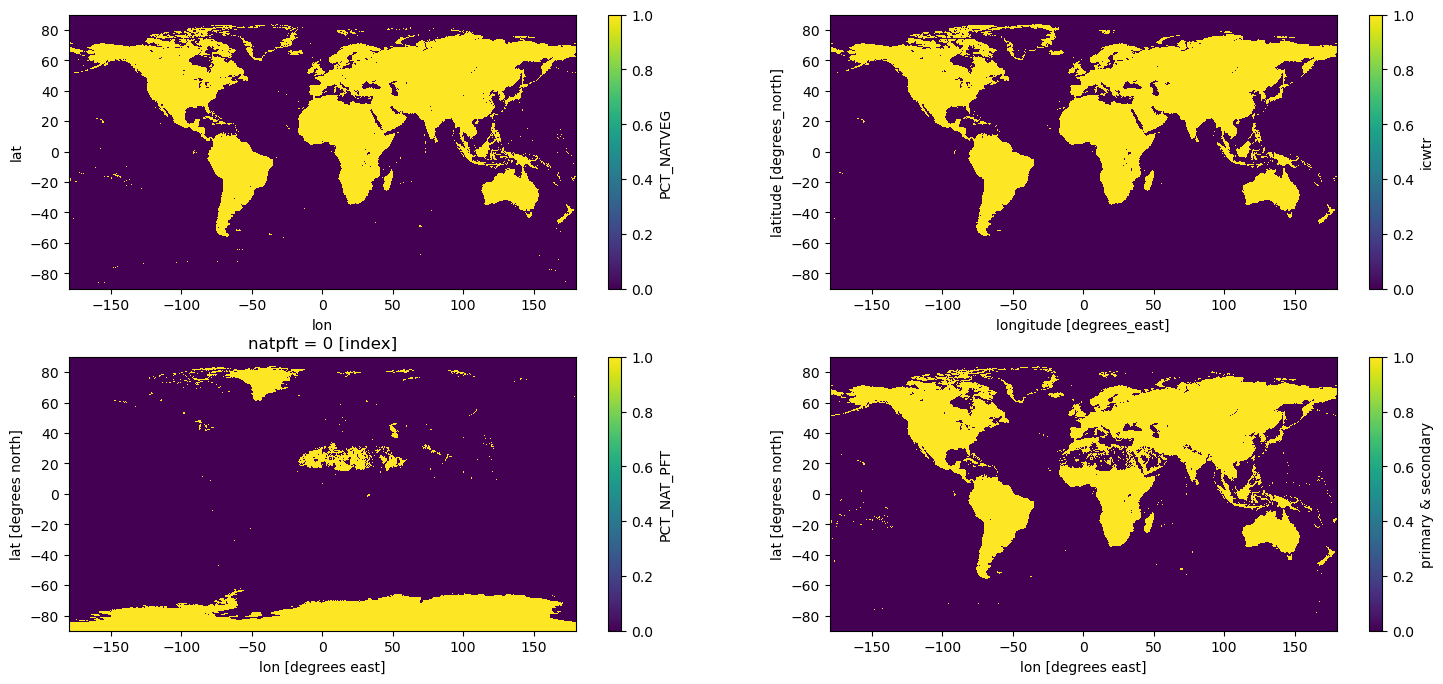

In [106]:
masklist = [mask_clmsurf_copy, mask_static_not_01, mask_bareground_100p, mask_miss_prim_sec]
f, ax = plt.subplots(2, 2, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25)
for i,ai in enumerate(ax.flat):
    masklist[i].plot(ax=ai)
    # ai.set_title(masklist[i].name)

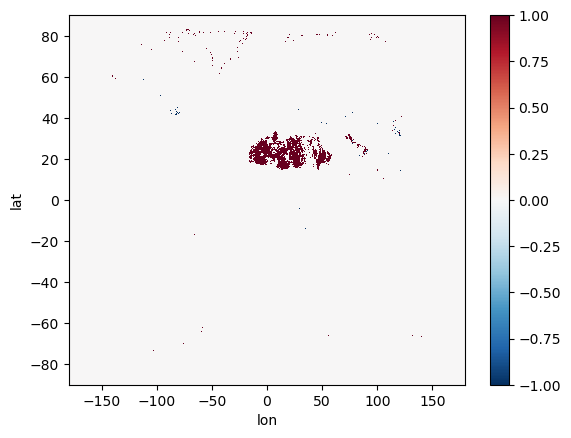

In [107]:
(mask_clmsurf_copy - mask_miss_prim_sec).plot()

## Combining masks

In [14]:
a = np.array([[1,0,1],[1,1,1]])
b = np.array([[1,1,0],[0,0,1]])

In [15]:
a * b

array([[1, 0, 0],
       [0, 0, 1]])

In [16]:
A = xr.DataArray(a)
B = xr.DataArray(b)

In [17]:
A*B

<xarray.DataArray (dim_0: 2, dim_1: 3)>
array([[1, 0, 0],
       [0, 0, 1]])
Dimensions without coordinates: dim_0, dim_1

In [29]:
A.values

array([[1, 0, 1],
       [1, 1, 1]])

In [30]:
B.values

array([[1, 1, 0],
       [0, 0, 1]])

In [46]:
xr.where(B,0,1)

<xarray.DataArray (dim_0: 2, dim_1: 3)>
array([[0, 0, 1],
       [1, 1, 0]])
Dimensions without coordinates: dim_0, dim_1

In [47]:
A.where(B)

<xarray.DataArray (dim_0: 2, dim_1: 3)>
array([[ 1.,  0., nan],
       [nan, nan,  1.]])
Dimensions without coordinates: dim_0, dim_1

In [48]:
A.where(B,0)

<xarray.DataArray (dim_0: 2, dim_1: 3)>
array([[1, 0, 0],
       [0, 0, 1]])
Dimensions without coordinates: dim_0, dim_1

**MASKING one with the other in this way is not the same as xr.where!!!**

xr.where(condition, true, false) values
xr.DataArray(condition, false, drop)

In [49]:
A.where(B,1)

<xarray.DataArray (dim_0: 2, dim_1: 3)>
array([[1, 0, 1],
       [1, 1, 1]])
Dimensions without coordinates: dim_0, dim_1

In [31]:
np.logical_and(A,B)

<xarray.DataArray (dim_0: 2, dim_1: 3)>
array([[ True, False, False],
       [False, False,  True]])
Dimensions without coordinates: dim_0, dim_1

## Takeaway: multiplying binary masks is the same as logical_and, which is the same as masking one with the other, but returning zero if false

In [52]:
np.logical_xor(A,B)

<xarray.DataArray (dim_0: 2, dim_1: 3)>
array([[False,  True,  True],
       [ True,  True, False]])
Dimensions without coordinates: dim_0, dim_1